In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as sim

import mltools.utils.cuda_tools as cuda_tools
from mltools.networks import networks

device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import models
import importlib
importlib.reload(utils)

plt.rcParams.update({'font.size': 18})

memory_available [77761]
best GPU: 0


In [4]:
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/*/seed=*"):
for fol in glob.glob("../data/images_1/2x2_final2/col_sweep/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/size_sweep/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/detailed/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4_sfixed/*/seed=*"):
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    plot_data_file=os.path.join(fol,"plot_data_reg.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
len(plot_datass),c

(20, 100)

In [5]:
import scipy.ndimage as sim
def get_i_learned(accs,consistent=3):
    assert consistent%2==1
    #find portion of acc where accs is positive for 3 values
    structure=np.ones(consistent)
    goods=sim.binary_erosion(accs,structure=structure)
    inds=np.nonzero(goods)[0]
    if len(inds)>=1:
        return np.min(inds)
    else:
        return None

In [6]:
sep_cols,sep_sizes=zip(*plot_datass.keys())
sep_cols=np.array(sep_cols)
sep_cols=np.unique(sep_cols)
sep_cols_float=np.array([float(x) for x in sep_cols])
sep_sizes=np.array(sep_sizes)
sep_sizes=np.unique(sep_sizes)
sep_sizes_float=np.array([float(x) for x in sep_sizes])
sep_cols,sep_sizes

(array(['0.1', '0.137', '0.174', '0.211', '0.247', '0.284', '0.321',
        '0.358', '0.395', '0.432', '0.468', '0.505', '0.542', '0.579',
        '0.616', '0.653', '0.689', '0.726', '0.763', '0.8'], dtype='<U5'),
 array(['0.4'], dtype='<U3'))

In [7]:
import scipy.ndimage as sim
t_cols=np.full((len(sep_cols),len(sep_sizes)),np.nan)
t_cols_s=np.full((len(sep_cols),len(sep_sizes)),np.nan)
t_sizes=np.full((len(sep_cols),len(sep_sizes)),np.nan)
t_sizes_s=np.full((len(sep_cols),len(sep_sizes)),np.nan)
for key,plot_datas in plot_datass.items():
    sep_col=key[0]
    sep_size=key[1]
    i_sep_col=np.where(sep_cols==sep_col)[0][0]
    i_sep_size=np.where(sep_sizes==sep_size)[0][0]

    yss_pred_tr=[]
    yss_te=[]
    for i in range(len(plot_datas)):
        plot_data=plot_datas[i]
        save_steps=plot_data["save_steps"]
        #rights_tr=plot_data["rightprobss_tr"]
        #rights_te=plot_data["rightprobss_te"]
        ys_tr=plot_data["ys_tr"]
        ys_te=plot_data["ys_te"]
        rightss_tr.append(rights_tr)
        rightss_te.append(rights_te)
    rightss_tr=np.stack(rightss_tr,axis=0)
    rightss_te=np.stack(rightss_te,axis=0)
    rightss_te=rightss_te.astype(np.float32)
    accs_m=rightss_te.mean(2)
    accs_s=rightss_te.std(2)
    #accs_smoothed=sim.gaussian_filter1d(accs_m-0.25*accs_s,1.0,axis=1)
    accs_smoothed=sim.gaussian_filter1d(accs_m,1.5,axis=1)
    thres=0.9
    save_steps=plot_datas[0]["save_steps"]
    i_learned_cols=[get_i_learned(acc_smoothed[:,0]>thres,consistent=3) for acc_smoothed in accs_smoothed]
    i_learned_sizes=[get_i_learned(acc_smoothed[:,1]>thres,consistent=3) for acc_smoothed in accs_smoothed]
    step_learned_cols=[20000 if el is None else save_steps[el] for el in i_learned_cols]
    step_learned_sizes=[20000 if el is None else save_steps[el] for el in i_learned_sizes]
    t_cols[i_sep_col,i_sep_size]=np.mean(step_learned_cols)
    t_cols_s[i_sep_col,i_sep_size]=np.std(step_learned_cols,ddof=1)
    t_sizes[i_sep_col,i_sep_size]=np.mean(step_learned_sizes)
    t_sizes_s[i_sep_col,i_sep_size]=np.std(step_learned_sizes,ddof=1)
    #save_steps=plot_datas[0]["save_steps"]
    #if i_learned_col is None:
    #    t_cols[i_sep_col,i_sep_size]=np.nan
    #else:
    #    t_cols[i_sep_col,i_sep_size]=save_steps[i_learned_col]
    #if i_learned_size is None:
    #    t_sizes[i_sep_col,i_sep_size]=np.nan
    #else:
    #    t_sizes[i_sep_col,i_sep_size]=save_steps[i_learned_size]
"""
for i in range(5):
    plt.plot(save_steps,accs_smoothed[i,:,0],c="r",alpha=0.5)
    plt.plot(save_steps,accs_smoothed[i,:,1],c="b",alpha=0.5)
    plt.plot(save_steps,accs_smoothed.mean(0)[:,0],c="r")
    plt.plot(save_steps,accs_smoothed.mean(0)[:,1],c="b")
"""
None

KeyError: 'rights_tr'

Text(0.5, 0, '$\\Delta$ Size')

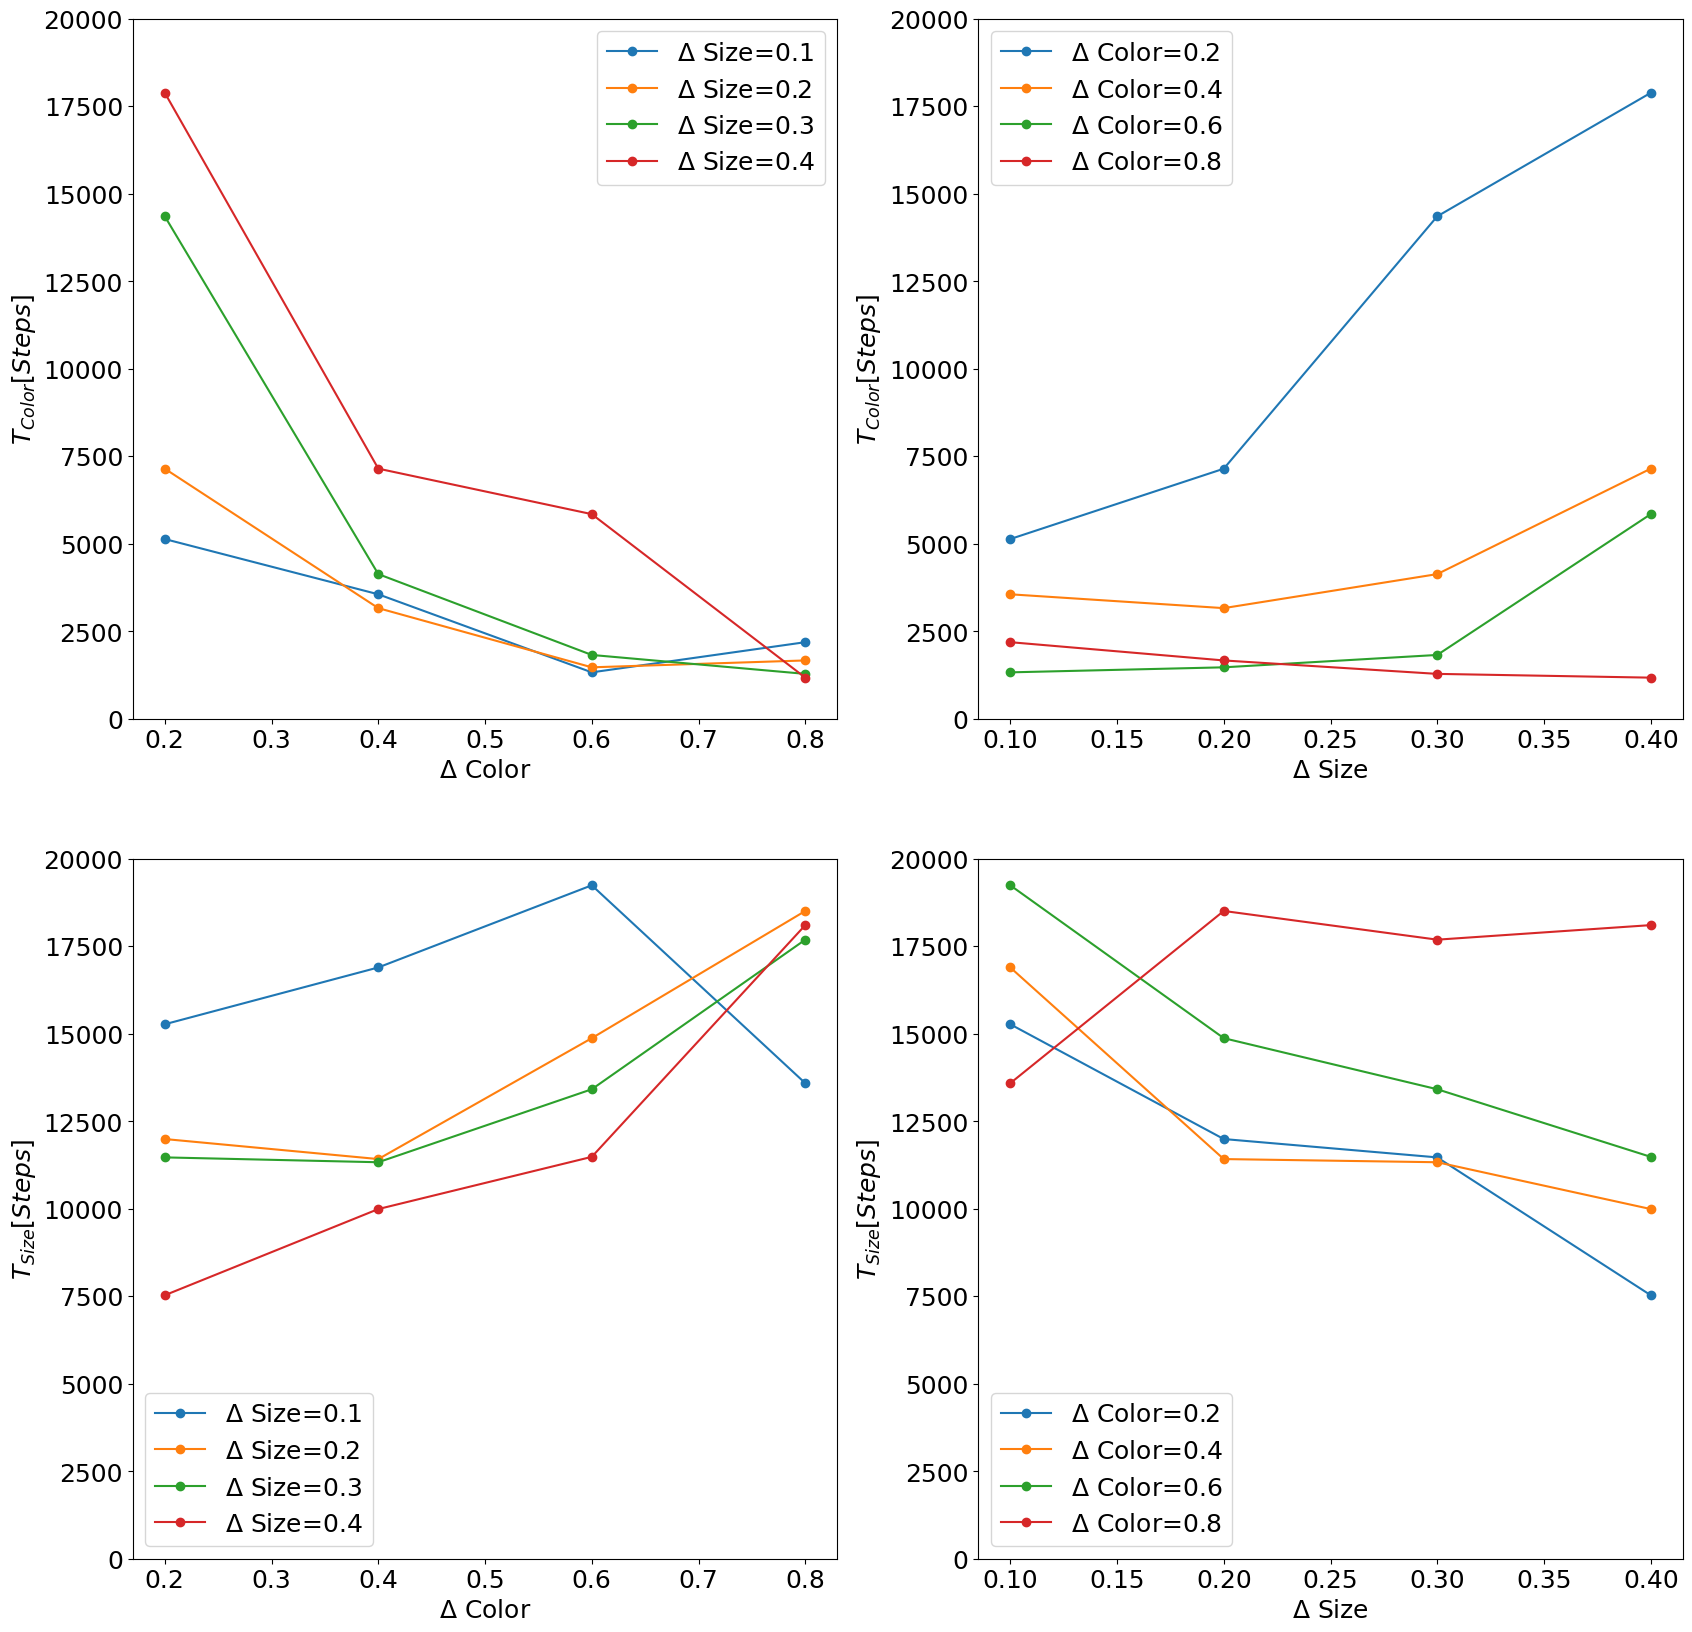

In [37]:
y_top=20000

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
for i in range(len(sep_sizes)):
    plt.plot(sep_cols_float,t_cols[:,i],label=r"$\Delta$ Size"+f"={sep_sizes[i]}",marker="o")
    #plt.fill_between(sep_cols_float,t_cols[:,i]-t_cols_s[:,i],t_cols[:,i]+t_cols_s[:,i],alpha=0.5)
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Color} [Steps]$")
plt.xlabel(r"$\Delta$ Color")
plt.subplot(2,2,2)
for i in range(len(sep_cols)):
    plt.plot(sep_sizes_float,t_cols[i],label=r"$\Delta$ Color"+f"={sep_cols[i]}",marker="o")
    #plt.fill_between(sep_sizes_float,t_cols[i]-t_cols_s[i],t_cols[i]+t_cols_s[i],alpha=0.5)
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Color} [Steps]$")
plt.xlabel(r"$\Delta$ Size")

plt.subplot(2,2,3)
for i in range(len(sep_sizes)):
    plt.plot(sep_cols_float,t_sizes[:,i],label=r"$\Delta$ Size"+f"={sep_sizes[i]}",marker="o")
    #plt.fill_between(sep_cols_float,t_sizes[:,i]-t_sizes_s[:,i],t_sizes[:,i]+t_sizes_s[:,i],alpha=0.5)
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Size} [Steps]$")
plt.xlabel(r"$\Delta$ Color")
plt.subplot(2,2,4)
for i in range(len(sep_cols)):
    plt.plot(sep_sizes_float,t_sizes[i],label=r"$\Delta$ Color"+f"={sep_cols[i]}",marker="o")
    #plt.fill_between(sep_sizes_float,t_sizes[i]-t_sizes_s[i],t_sizes[i]+t_sizes_s[i],alpha=0.5)
plt.legend()
plt.ylim(0,y_top)
plt.ylabel(r"$T_{Size} [Steps]$")
plt.xlabel(r"$\Delta$ Size")
#plt.savefig("../figures/final/learning_times.png")

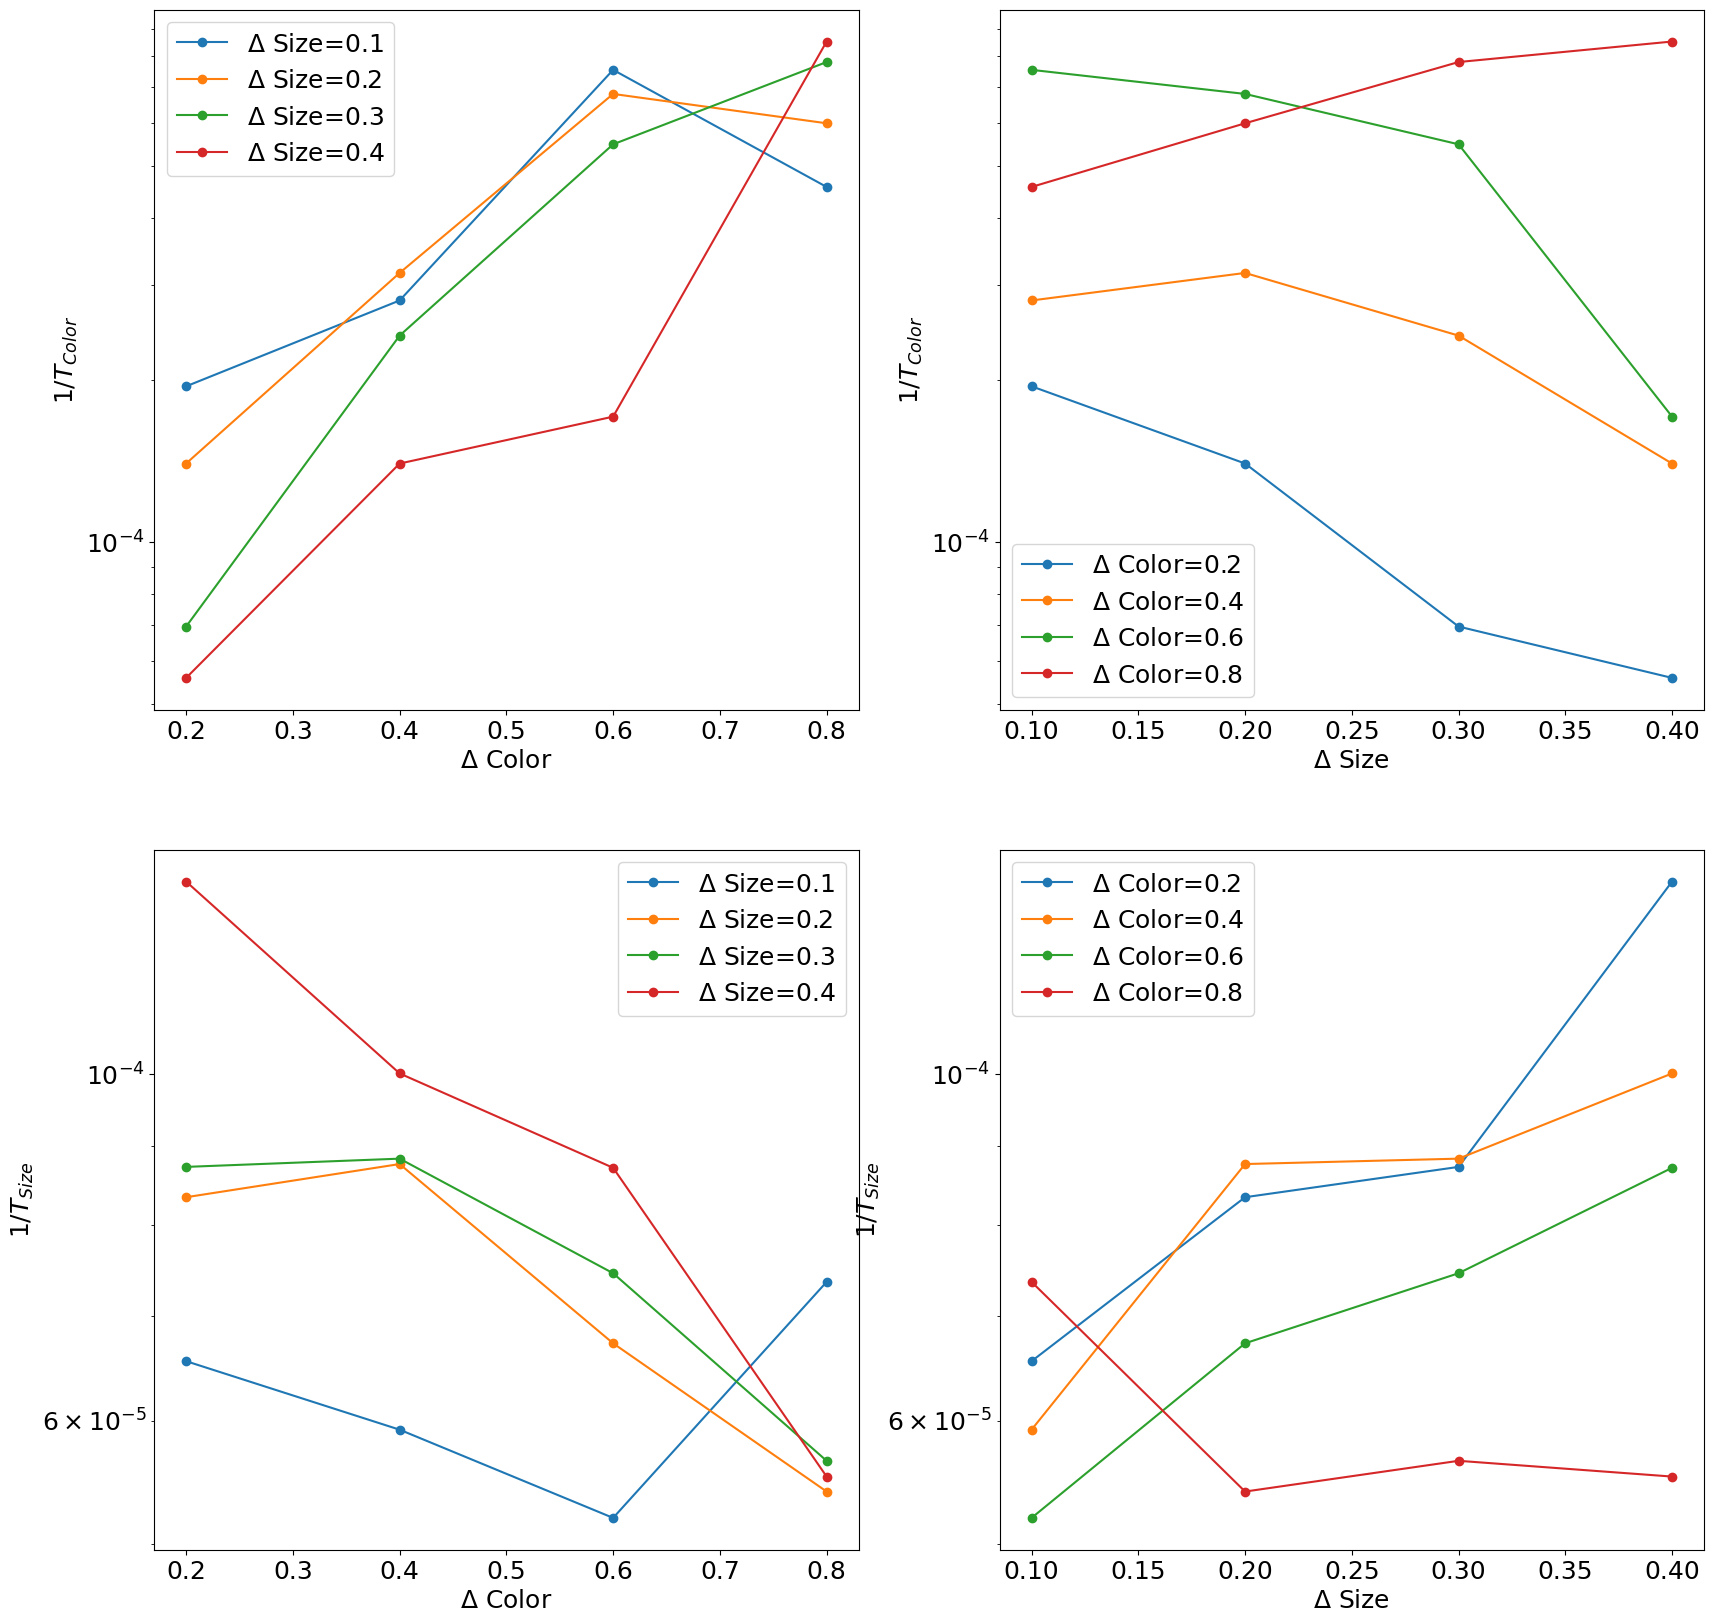

In [38]:
y_top=20000

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
for i in range(len(sep_sizes)):
    plt.plot(sep_cols_float,1/t_cols[:,i],label=r"$\Delta$ Size"+f"={sep_sizes[i]}",marker="o")
plt.legend()
plt.ylabel(r"$1/T_{Color}$")
plt.xlabel(r"$\Delta$ Color")
plt.yscale("log")

plt.subplot(2,2,2)
for i in range(len(sep_cols)):
    plt.plot(sep_sizes_float,1/t_cols[i],label=r"$\Delta$ Color"+f"={sep_cols[i]}",marker="o")
plt.legend()
plt.ylabel(r"$1/T_{Color}$")
plt.xlabel(r"$\Delta$ Size")
plt.yscale("log")

plt.subplot(2,2,3)
for i in range(len(sep_sizes)):
    plt.plot(sep_cols_float,1/t_sizes[:,i],label=r"$\Delta$ Size"+f"={sep_sizes[i]}",marker="o")
plt.legend()
plt.ylabel(r"$1/T_{Size}$")
plt.xlabel(r"$\Delta$ Color")
plt.yscale("log")

plt.subplot(2,2,4)
for i in range(len(sep_cols)):
    plt.plot(sep_sizes_float,1/t_sizes[i],label=r"$\Delta$ Color"+f"={sep_cols[i]}",marker="o")
plt.legend()
plt.ylabel(r"$1/T_{Size}$")
plt.xlabel(r"$\Delta$ Size")
plt.yscale("log")
#plt.savefig("../figures/final/learning_times_inv.png")

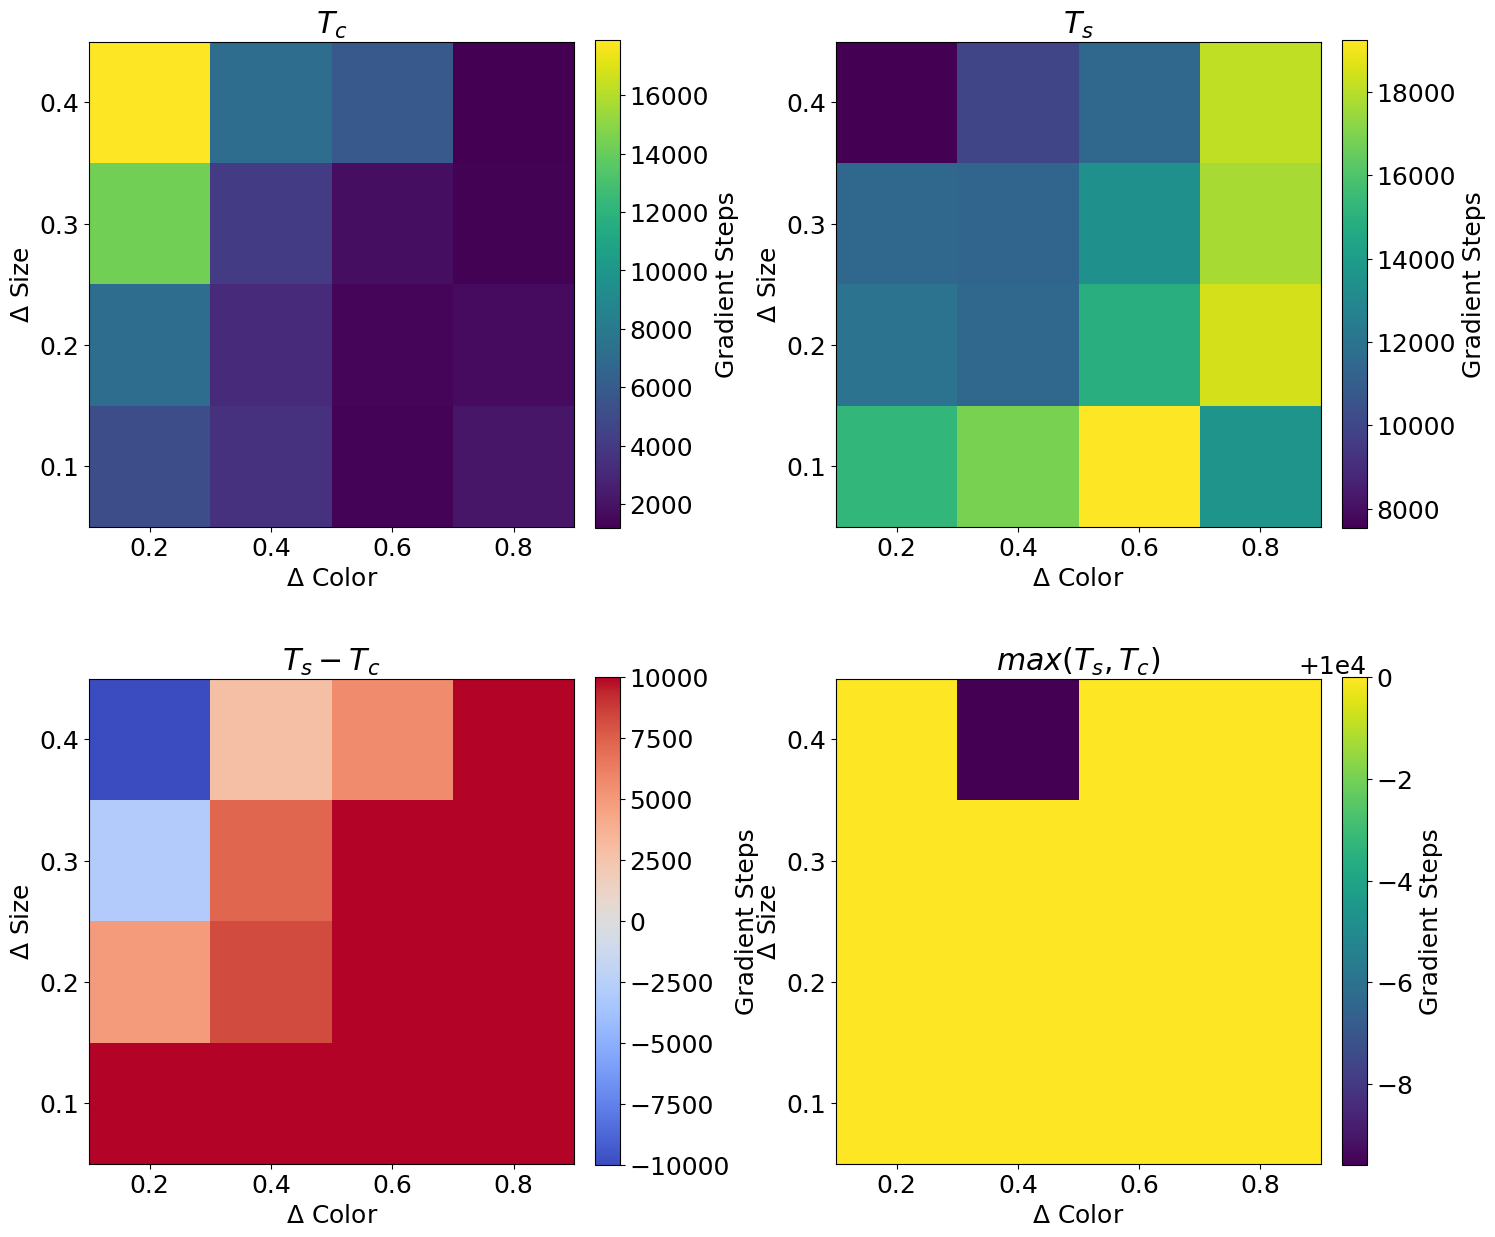

In [39]:
plt.figure(figsize=(15,13))
plt.subplot(2,2,1)
plt.imshow(t_cols.transpose(1,0),interpolation="none",origin="lower")
plt.xticks(range(len(sep_cols)),sep_cols)
plt.yticks(range(len(sep_sizes)),sep_sizes)
plt.colorbar(fraction=0.046, pad=0.04,label="Gradient Steps")
plt.xlabel(r"$\Delta$ Color")
plt.ylabel(r"$\Delta$ Size")
plt.title(r"$T_c$")

plt.subplot(2,2,2)
plt.imshow(t_sizes.transpose(1,0),interpolation="none",origin="lower")
plt.xticks(range(len(sep_cols)),sep_cols)
plt.yticks(range(len(sep_sizes)),sep_sizes)
plt.colorbar(fraction=0.046, pad=0.04,label="Gradient Steps")
plt.xlabel(r"$\Delta$ Color")
plt.ylabel(r"$\Delta$ Size")
plt.title(r"$T_s$")
plt.subplot(2,2,3)
plt.imshow((t_sizes-t_cols).transpose(1,0),interpolation="none",origin="lower",cmap="coolwarm",vmin=-10000,vmax=10000)
plt.xticks(range(len(sep_cols)),sep_cols)
plt.yticks(range(len(sep_sizes)),sep_sizes)
plt.colorbar(fraction=0.046, pad=0.04,label="Gradient Steps")
plt.xlabel(r"$\Delta$ Color")
plt.ylabel(r"$\Delta$ Size")
plt.title(r"$T_s-T_c$")
plt.subplot(2,2,4)
plt.imshow(np.maximum(t_sizes,t_cols).transpose(1,0),interpolation="none",origin="lower",vmax=10000)
plt.xticks(range(len(sep_cols)),sep_cols)
plt.yticks(range(len(sep_sizes)),sep_sizes)
cb=plt.colorbar(fraction=0.046, pad=0.04,label="Gradient Steps")
plt.xlabel(r"$\Delta$ Color")
plt.ylabel(r"$\Delta$ Size")
plt.title(r"$max(T_s,T_c)$")
plt.tight_layout()
#plt.savefig("../figures/final/learning_times_2d.png")


In [31]:
#_=plt.scatter((t_sizes-t_cols),np.maximum(t_sizes,t_cols),s=10)
#plt.xlabel(r"$T_s-T_c$")

In [27]:
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/*/seed=*"):
for fol in glob.glob("../data/images_1/2x2_final2/col_sweep/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/col_sweep_inis=0.1/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/col_sweep_wd=0.05/*/seed=*"):
    config_path=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(config_path)
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    plot_data_file=os.path.join(fol,"plot_data_reg.pth")
    #if not os.path.exists(plot_data_file):
    #    continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_data["config"]=config
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
    #if "seed=0" in fol:
    #    print(sep_col)
len(plot_datass),c

(20, 100)

In [28]:
config=utils.load_config('../data/images_1/2x2_final2/col_sweep/sep_col=0.8_sep_size=0.4/seed=0/seed=0.yaml')
#config=utils.load_config('../data/images_1/2x2_final2/col_sweep_inis=0.1/sep_col=0.8_sep_size=0.4/seed=0/seed=0.yaml')
#config=utils.load_config('../data/images_1/2x2_final2/col_sweep_wd=0.05/sep_col=0.8_sep_size=0.4/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)

In [29]:
i_step_min=3
plot_datas=plot_datass[list(plot_datass.keys())[0]]
save_steps=plot_datas[0]["save_steps"]
save_steps[i_step_min]

807

In [30]:
cmap="gnuplot"
norm = mcolors.Normalize(vmin=0.1, vmax=0.8)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

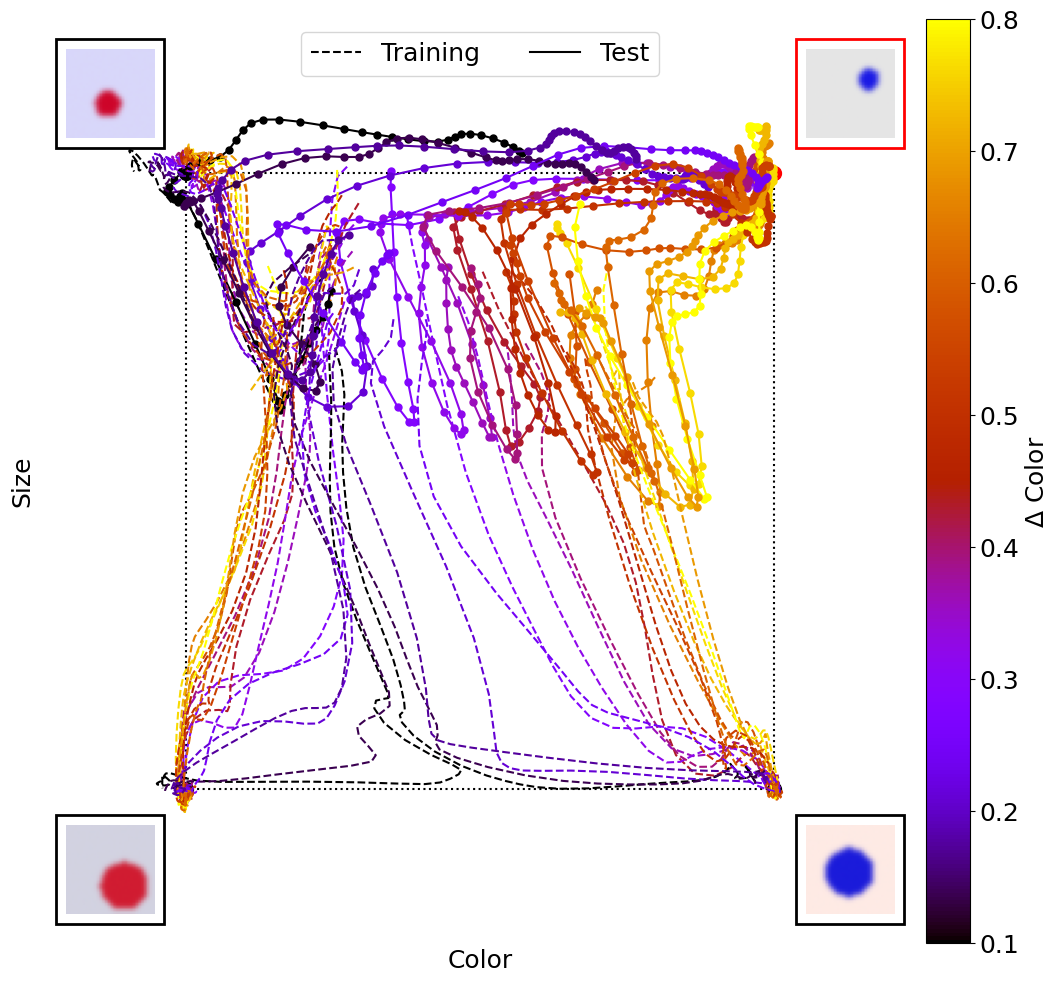

In [52]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
trajs_trss=[]
trajs_tess=[]
sep_cols=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_cols.append(float(sep_col))
    plot_datas=plot_datass[key]
    ys_pred_trs=[]
    ys_pred_tes=[]
    for plot_data in plot_datas:
        ys_pred_tr=np.array(plot_data['ys_pred_tr'])
        l_tr=np.array(plot_data['l_tr'])
        ys_pred_trs.append(ys_pred_tr)
        ys_pred_te=np.array(plot_data['ys_pred_te'])
        ys_pred_tes.append(ys_pred_te)
        l_te=np.array(plot_data['l_te'])
    ys_pred_trs=np.stack(ys_pred_trs,axis=0)
    ys_pred_tes=np.stack(ys_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(ys_pred_trs[:,:,l_tr==i].mean((0,2)))#over seed and samples
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=ys_pred_tes[:,:,l_te==3].mean((0,2))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    color=sep_col_to_color(sep_col,cmap=cmap)
    color_means=np.array(plot_datas[0]["config"]["data_params"]["color"]["means"])
    c_vec=color_means[1]-color_means[0]
    c_unit_vec=c_vec/np.linalg.norm(c_vec)
    c0proj=color_means[0]@c_unit_vec
    c1proj=color_means[1]@c_unit_vec
    size_means=np.array(plot_datas[0]["config"]["data_params"]["size"]["means"])
    def get_xy(traj):
        col=traj[:,4:7]
        size=traj[:,7]
        x=col@c_unit_vec#project on color axis
        x=(x-c0proj)/(c1proj-c0proj)
        y=(size-size_means[0])/(size_means[1]-size_means[0])
        return x,y
    x,y=get_xy(trajs_te)
    plt.plot(x[i_step_min:],y[i_step_min:],marker="o",c=color,markersize=5)
    i_star=20
    #plt.plot(x[i_star],y[i_star],marker="*",c="r",markersize=20)
    for i in range(3):
        x,y=get_xy(trajs_trs[i])
        plt.plot(x[i_step_min:],y[i_step_min:],ls="--",c=color)
        #plt.plot(x[i_star],y[i_star],marker="*",c="r",markersize=20)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Color")
plt.savefig("../figures/final/training_dynamics_sep_col_reg.png")

In [47]:
color_means[1]-color_means[0]

array([-0.284,  0.   ,  0.284])

In [52]:
sep_cols=np.array(sep_cols)

In [46]:
trajs_trss=np.stack(trajs_trss,axis=0)
displacement_trss=np.linalg.norm(np.gradient(trajs_trss,save_steps,axis=2),axis=3)
trajs_trss.shape

(20, 3, 60, 2)

In [47]:
trajs_tess=np.stack(trajs_tess,axis=0)
displacement_tess=np.linalg.norm(np.gradient(trajs_tess,save_steps,axis=1),axis=2)

In [88]:
displacement_trss_m=displacement_trss.mean((0,1))
displacement_trss_s=displacement_trss.std((0,1),ddof=1)
displacement_trss_cm=displacement_trss.mean(1)
log_displacement_trss_cm=np.log(displacement_trss_cm)

displacement_tess_m=displacement_tess.mean(0)
displacement_tess_s=displacement_tess.std(0,ddof=1)
displacement_tess_cm=displacement_tess
log_displacement_tess_cm=np.log(displacement_tess_cm)

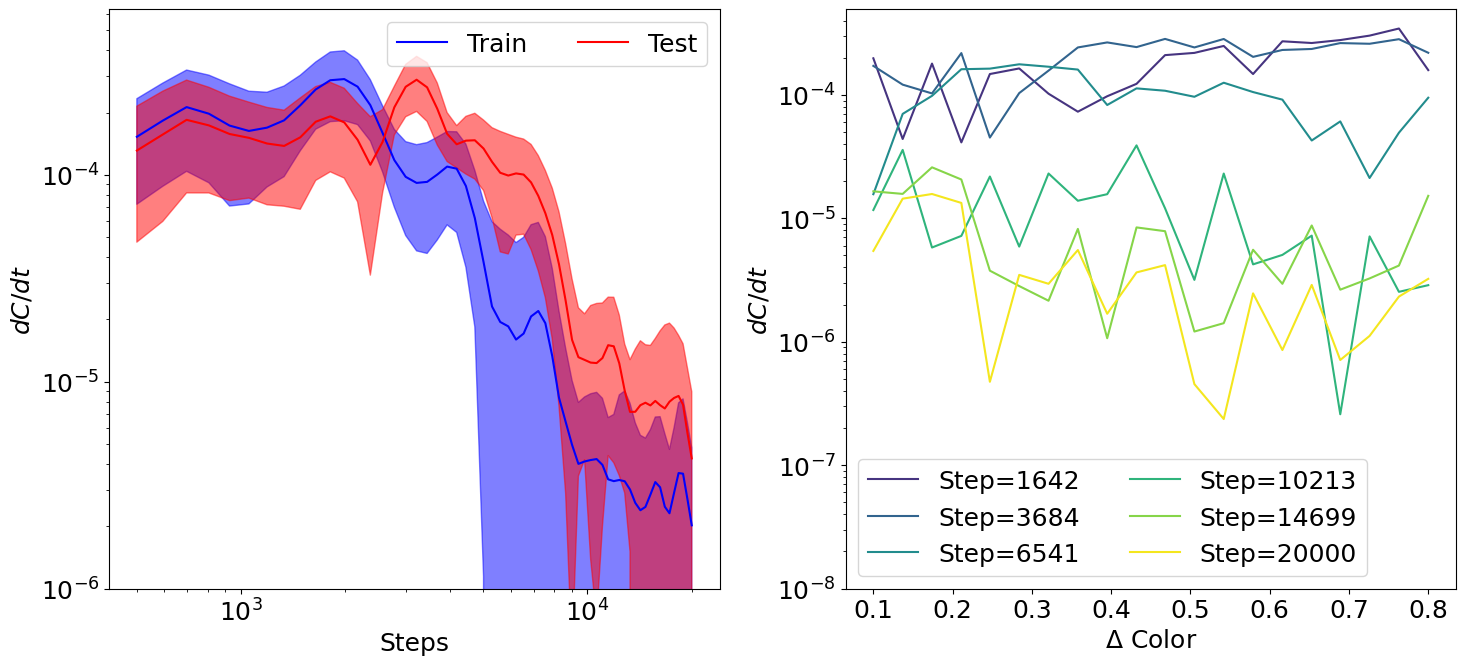

In [117]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(save_steps,displacement_trss_m,c="b",label="Train")
plt.fill_between(save_steps,displacement_trss_m-displacement_trss_s,displacement_trss_m+displacement_trss_s,alpha=0.5,color="b")
plt.plot(save_steps,displacement_tess_m,c="r",label="Test")
plt.fill_between(save_steps,displacement_tess_m-displacement_tess_s,displacement_tess_m+displacement_tess_s,alpha=0.5,color="r")
plt.yscale("log")
plt.xscale("log")
plt.ylim(bottom=1e-6)
plt.ylabel(r"$dC/dt$")
plt.xlabel("Steps")
plt.legend(ncol=2)

plt.subplot(1,2,2)
for i in [9,19,29,39,49,59]:
    indsort=np.argsort(sep_cols)
    step=save_steps[i]
    #_=plt.plot(sep_cols[indsort],displacement_trss_cm[:,i][indsort],c=matplotlib.colormaps["viridis"](i/60),ls="--",alpha=0.5)
    _=plt.plot(sep_cols[indsort],displacement_tess_cm[:,i][indsort],c=matplotlib.colormaps["viridis"](i/60),label=f"Step={step}")
plt.yscale("log")
plt.ylim(bottom=1e-8)
plt.ylabel(r"$dC/dt$")
plt.xlabel(r"$\Delta$ Color")
plt.legend(ncol=2)

plt.tight_layout()
#plt.savefig("../figures/final/dCdt.png")

In [80]:
log_steps=np.log(save_steps)

In [99]:
#variance explained from the two dimensions
import sklearn.linear_model as sklin
import sklearn.metrics as skmet
x_sep_cols=sep_cols[:,None].repeat(60,axis=1).reshape(-1,1)
x_log_steps=log_steps[None,:].repeat(20,axis=0).reshape(-1,1)
x_joint=np.concatenate([x_sep_cols,x_log_steps],axis=1)
y=log_displacement_trss_cm.reshape(-1,1)

linreg_sep_cols=sklin.LinearRegression()
linreg_sep_cols.fit(x_sep_cols,y)
r2_sep_cols=skmet.r2_score(y,linreg_sep_cols.predict(x_sep_cols))

linreg_log_steps=sklin.LinearRegression()
linreg_log_steps.fit(x_log_steps,y)
r2_log_steps=skmet.r2_score(y,linreg_log_steps.predict(x_log_steps))

linreg_joint=sklin.LinearRegression()
linreg_joint.fit(x_joint,y)
r2_joint=skmet.r2_score(y,linreg_joint.predict(x_joint))

r2_sep_cols,r2_log_steps,r2_joint

(0.010445819627637465, 0.7922229880231804, 0.8026688060810088)

In [48]:
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/*/seed=*"):
for fol in glob.glob("../data/images_1/2x2_final2/size_sweep/*/seed=*"):
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    plot_data_file=os.path.join(fol,"plot_data.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
    #if "seed=0" in fol:
    #    print(sep_col)
len(plot_datass),c

(20, 75)

In [49]:
fol

'../data/images_1/2x2_final2/size_sweep/sep_col=0.4_sep_size=0.316/seed=0'

In [50]:
config=utils.load_config('../data/images_1/2x2_final2/size_sweep/sep_col=0.4_sep_size=0.389/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)

In [55]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
plot_datas[0]["save_steps"][i_step_min]

594

In [56]:
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap="cubehelix"
norm = mcolors.Normalize(vmin=0.2, vmax=0.389)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

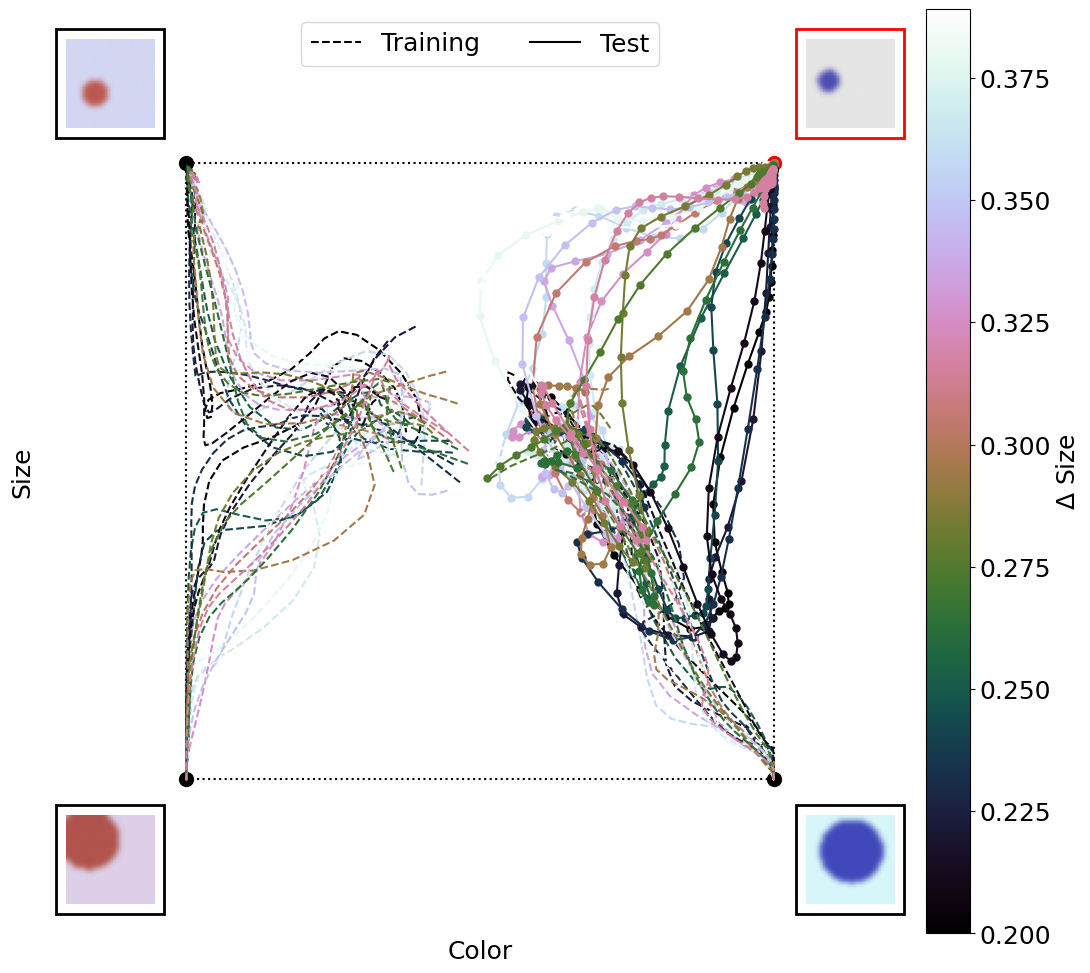

In [57]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
for key in plot_datass.keys():
    sep_size=key[1]
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0)
    color=sep_col_to_color(sep_size,cmap=cmap)
    plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",c=color,markersize=5)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Size")
plt.savefig("../figures/final/training_dynamics_sep_size.png")

In [135]:
plot_datass={}
c=0
for fol in glob.glob("../data/images_1/2x2_final2/detailed/*/seed=*"):
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    if (sep_col,sep_size) not in [("0.4","0.333"),("0.8","0.333"),("0.2","0.333"),("0.4","0.2"),("0.4","0.4")]:
        continue

    plot_data_file=os.path.join(fol,"plot_data.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
    #if "seed=0" in fol:
    #    print(sep_col)
len(plot_datass),c

(5, 25)

In [136]:
config=utils.load_config('../data/images_1/2x2_final2/detailed/sep_col=0.4_sep_size=0.333/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)

In [137]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
plot_datas[0]["save_steps"][i_step_min]

10

In [138]:
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap="gnuplot"
norm = mcolors.Normalize(vmin=0.2, vmax=0.389)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

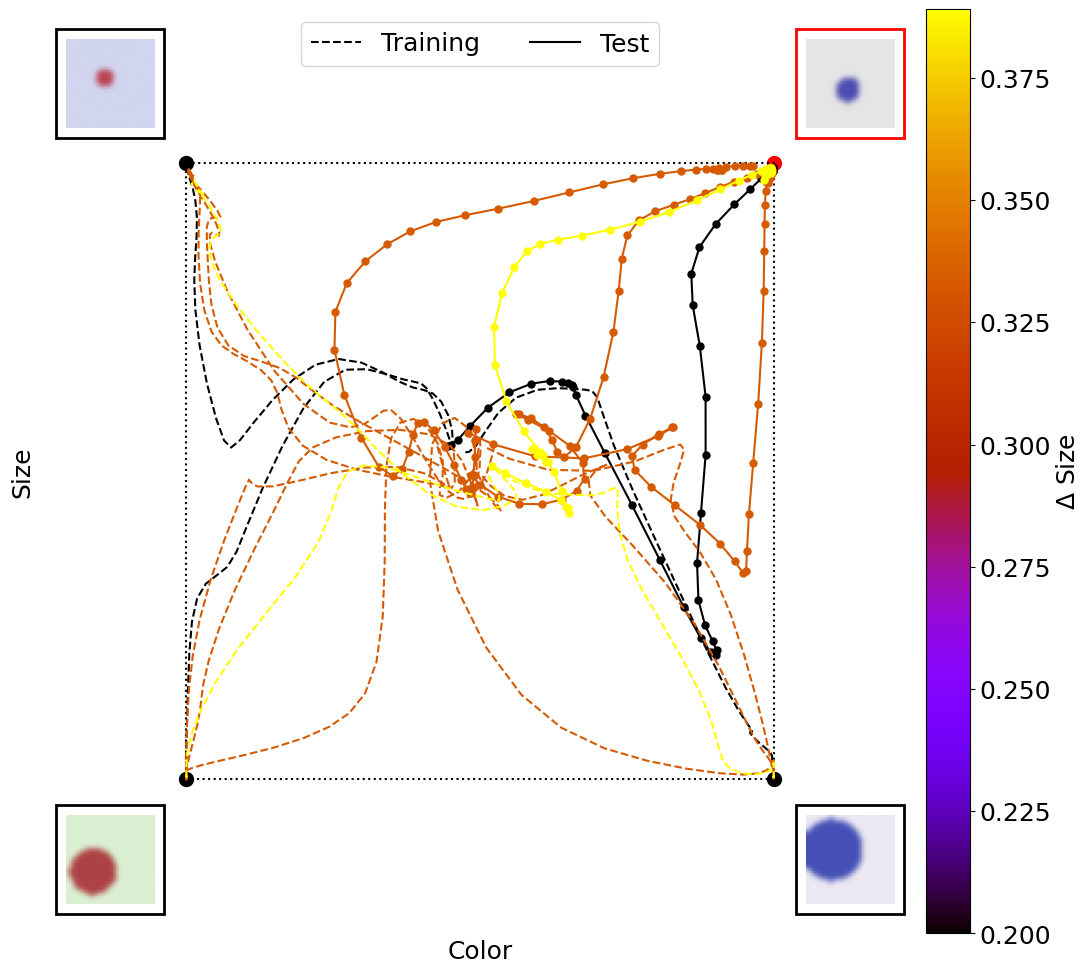

In [139]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
for key in plot_datass.keys():
    sep_size=key[1]
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0)
    color=sep_col_to_color(sep_size,cmap=cmap)
    plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",c=color,markersize=5)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Size")
plt.savefig("../figures/final/training_dynamics_scss.png")

ckpt stuff

In [ ]:
plot_datass={}
c=0
for fol in glob.glob("../data/images_1/2x2_final2/"):
    pass

In [60]:
ckpts=plot_datas[0]["ckpts"]
ckpt_keys=ckpts[0].keys()
tckpt={}
for key in ckpt_keys:
    if "model.score_model" not in key:
        continue
    key_=key.replace("model.score_model.","")
    tckpt[key_]=[]
    for ckpt in ckpts:
        tckpt[key_].append(ckpt[key])  
    tckpt[key_]=torch.stack(tckpt[key_],axis=0).cpu().numpy()
    print(key_,tckpt[key_].shape)

embed_t_conditioning.0.weight (60, 256, 64)
embed_t_conditioning.0.bias (60, 256)
embed_t_conditioning.2.weight (60, 256, 256)
embed_t_conditioning.2.bias (60, 256)
embedders.0.0.0.weight (60, 1024, 256)
embedders.0.0.0.bias (60, 1024)
embedders.0.0.2.weight (60, 1024, 1024)
embedders.0.0.2.bias (60, 1024)
embedders.0.1.0.weight (60, 1024, 2)
embedders.0.1.0.bias (60, 1024)
embedders.0.1.2.weight (60, 1024, 1024)
embedders.0.1.2.bias (60, 1024)
layers.0.weight (60, 1024, 2)
layers.0.bias (60, 1024)
layers.1.weight (60, 2, 1024)
layers.1.bias (60, 2)


In [61]:
tckpt['embedders.0.1.2.weight'].shape

(60, 1024, 1024)

In [62]:
eigvs=np.linalg.eigvals(tckpt['embedders.0.1.2.weight'])
eigvs.shape

(60, 1024)

In [63]:
eigvs_abs=np.abs(eigvs)**2

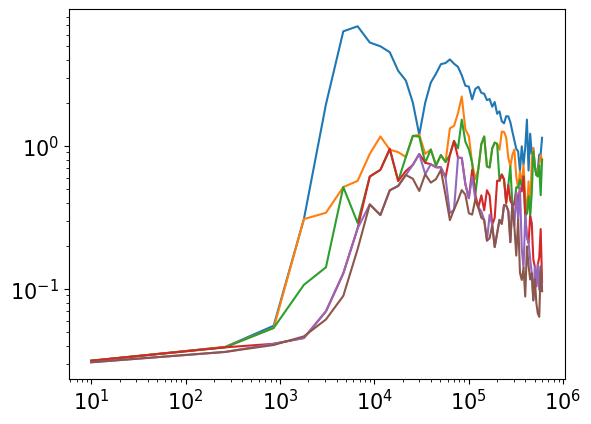

In [64]:
plt.plot(save_steps,eigvs_abs[:,0])
plt.plot(save_steps,eigvs_abs[:,1])
plt.plot(save_steps,eigvs_abs[:,2])
plt.plot(save_steps,eigvs_abs[:,3])
plt.plot(save_steps,eigvs_abs[:,4])
plt.plot(save_steps,eigvs_abs[:,5])
plt.xscale("log")
plt.yscale("log")

In [65]:
def mMn(vals):
    m=vals.min()
    M=vals.max()
    return (vals-m)/(M-m)

Text(0, 0.5, 'Eigenvalue')

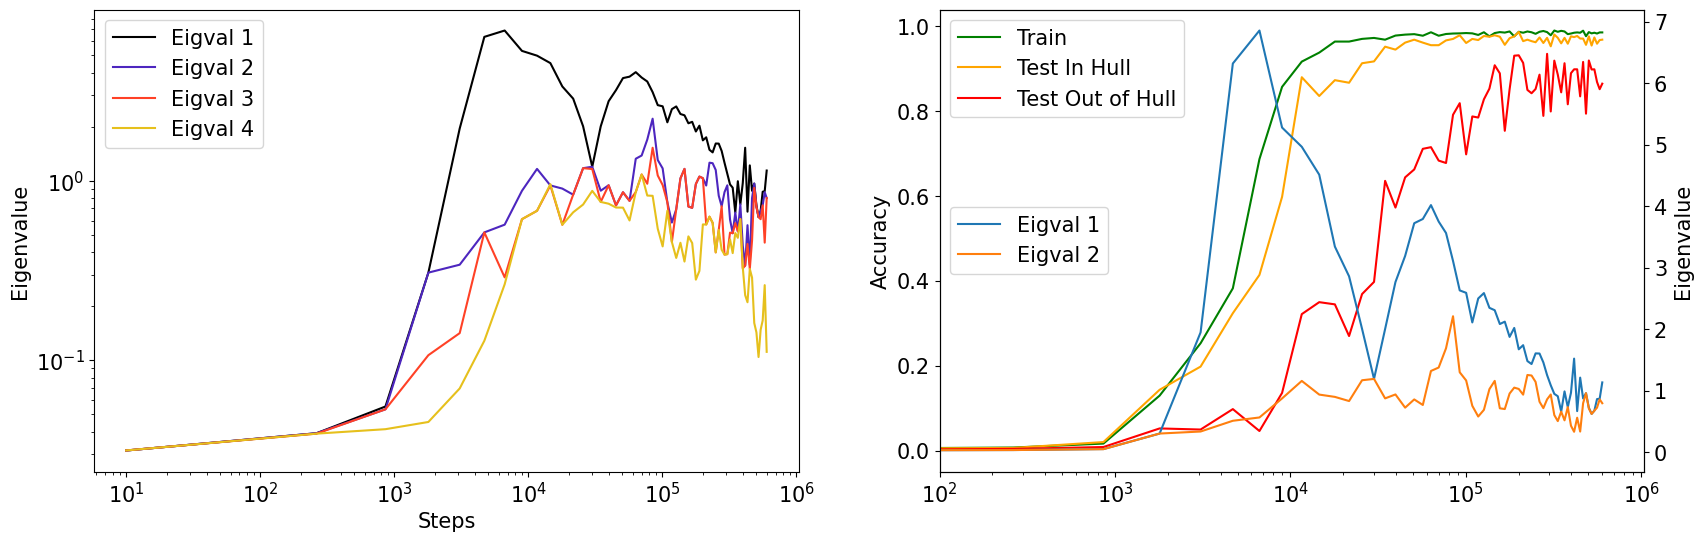

In [66]:
x_left=100
plt.figure(figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.subplot(1,2,1)
cmap=plt.get_cmap("CMRmap")
for i in range(4):
    plt.plot(save_steps,eigvs_abs[:,i],color=cmap(i/4),label="Eigval "+str(i+1))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
plt.legend()

plt.subplot(1,2,2)
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
plt.xscale("log")
plt.legend()
plt.xlim(left=x_left)
plt.ylabel("Accuracy")
plt.twinx()
plt.plot(save_steps,eigvs_abs[:,0],label="Eigval 1")
plt.plot(save_steps,eigvs_abs[:,1],label="Eigval 2")
plt.legend(loc="center left")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
#plt.savefig("./figures/eigen_predict.png")

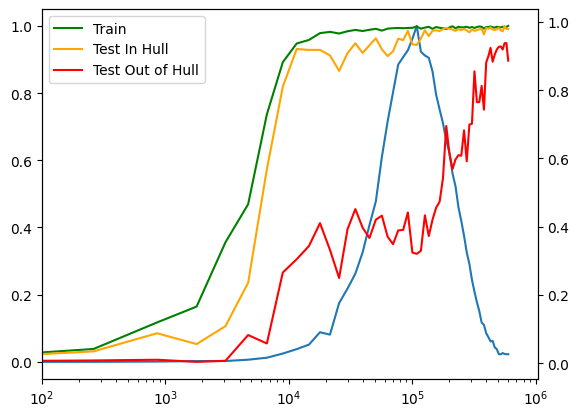

In [20]:
x_left=100
min_vlb=plot_data["min_vlb"]
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.weight'][:,:,0],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.bias'][:,:],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.2.bias'][:,:],axis=1))
plt.plot(save_steps,mMn(eigvs_abs[:,0]),label="Max. Eigval. of Cond. Proj.")
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.weight'][:,:,0],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.bias'],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.1.bias'],axis=1)))
plt.xscale("log")
plt.xlim(left=x_left)
#plt.twinx()
#plt.plot(save_steps,val_losses-min_vlb,c="green",alpha=0.5)
#plt.plot(save_steps,te_losses-min_vlb,c="red",alpha=0.5)
#plt.yscale("log")
plt.twinx()
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
#plt.plot(save_steps,acctr_m,c="green",ls="--")
#plt.plot(save_steps,accte_m,c="red",ls="--")
plt.legend()
